# Sampling techniques

How to sample according to a given positive and integrable function, i.e. a density function with an unknown constant of normalization?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform
from statsmodels.tsa.stattools import acovf

C:\Users\jolyc\mambaforge\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def f_to_sample(x):
    xmin, xmax = 0, 5
    return np.where((xmin <= x) & (x <= xmax), 1.5*np.exp(-np.abs(x-4)) + (x**1*(5-x)**8)/10e4, 0)

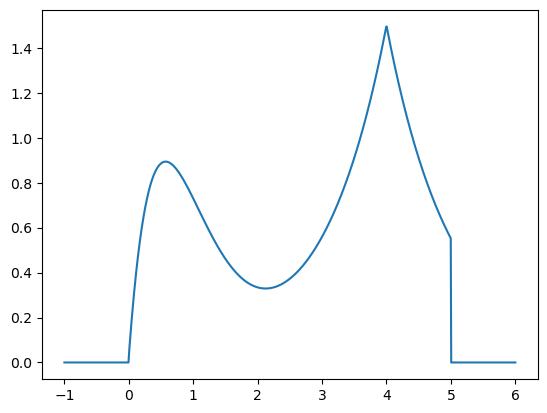

In [3]:
x = np.linspace(-1, 6, 1000)

plt.plot(x, f_to_sample(x))
plt.show()

## 1. Rejection sampling

In [4]:
def sample_reject(f, g, c, n_samples, verbose=False):
    ret = []
    k = 0
    while len(ret) < n_samples:
        s = g.rvs()
        r = f(s)/(c * g.pdf(s))
        if r > 1:
            raise ValueError("`c` is not large enough !")
        else:
            if uniform.rvs() <= r:
                ret.append(s)
        k += 1
    if verbose:
        print(f"{100*(k-n_samples)/k:.2f}% of samples were rejected")
    return np.array(ret)

56.30% of samples were rejected
CPU times: total: 2.61 s
Wall time: 2.72 s


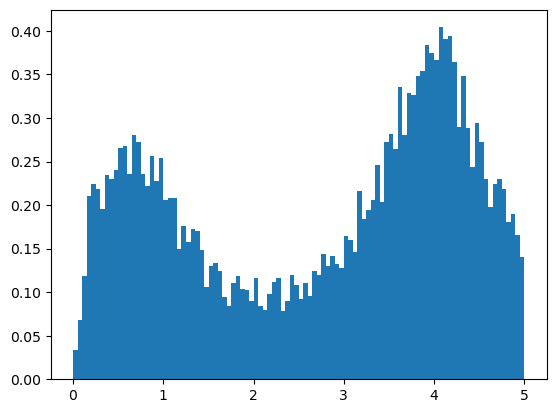

In [5]:
%time samples = sample_reject(f=f_to_sample, g=uniform(0, 5), c=8, n_samples=10000, verbose=True)

n_bins = 100

plt.hist(samples, bins=n_bins, density=True)
plt.show()

Are the drawn samples correlated ? No, they are not.

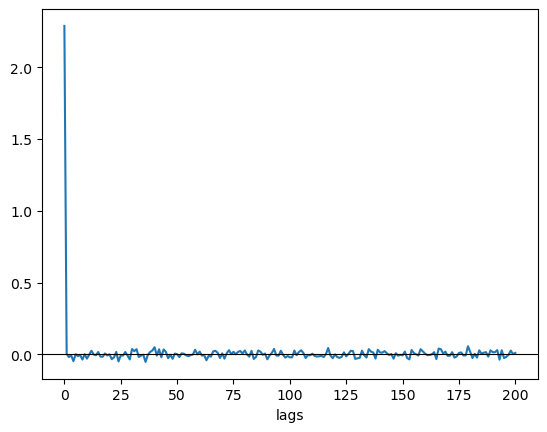

In [6]:
plt.plot(acovf(samples, nlag=200))
plt.axhline(y=0, c='k', lw=0.8)
plt.xlabel('lags')
plt.show()

## 2. Metropolis sampling

In [7]:
def metropolis(f, x0, proposal_generator, n_samples):
    ret = []
    current_state = x0
    for _ in range(n_samples):
        proposed_state = current_state + proposal_generator.rvs()
        acceptance_ratio = min(1, f(proposed_state) / f(current_state))
        if uniform.rvs() <= acceptance_ratio:
            current_state = proposed_state
        ret.append(current_state)
    return np.array(ret)

CPU times: total: 625 ms
Wall time: 657 ms


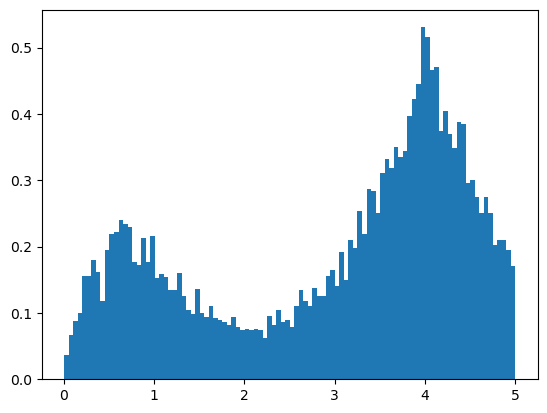

In [8]:
%time samples = metropolis(f=f_to_sample, x0=2.5, proposal_generator=norm(0, 0.5), n_samples=10000)

plt.hist(samples, bins=n_bins, density=True)
plt.show()

The Metropolis algorithm implies possibly "staying" at the same spot in some iterations. One can compute the percentage of unique values among the drawn samples:

In [9]:
100*len(np.unique(samples)) / len(samples)

78.94

Are the samples drawn correlated ? Yes they are.

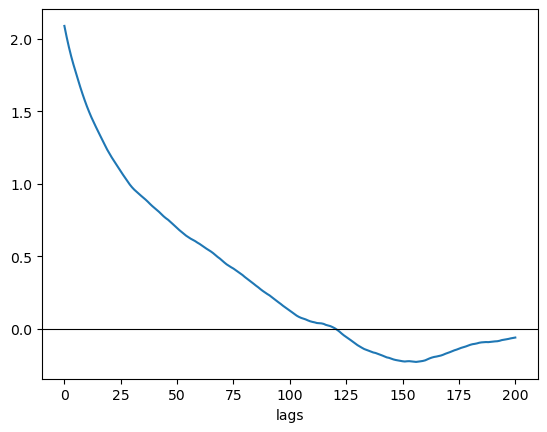

In [10]:
plt.plot(acovf(samples, nlag=200))
plt.axhline(y=0, c='k', lw=0.8)
plt.xlabel('lags')
plt.show()